In [1]:
# Training model is optimized for Google Colab interface

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib
import os
import glob
import torch
import statistics
import seaborn as sns
import time
import random
import keras.backend as K

from PIL import Image
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold, train_test_split
from keras.optimizers import SGD, Adagrad, Adam, Nadam
from sklearn.metrics import confusion_matrix
from google.colab import files

In [2]:
# Take dataset directly from Kaggle

!pip install opendatasets
import opendatasets as od

od.download(
    "https://www.kaggle.com/datasets/aliaslandemir/classcrossfin")

# Kaggle username: aliaslandemir
# Kaggle Key: 6f8335ed8437205e08381585952f57ed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aliaslandemir
Your Kaggle Key: ··········


100%|██████████| 12.3M/12.3M [00:01<00:00, 8.15MB/s]


In [3]:
%matplotlib inline

# Random seed functions to provide same sequence for each run

np.random.seed(42);
torch.manual_seed(42);
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Using pandas dataframe to load images with labels taken from https://www.kaggle.com/code/taejoopark/kfold-for-small-image-dataset-vgg16-94-test-acc/notebook

data_path = 'classcrossfin'

# Glob all 'jpg' image files
img_paths = glob.glob(data_path + '/**/*.jpg', recursive=True)

# Extract label names
img_labels = [os.path.split(os.path.dirname(path))[1] for path in img_paths]

# Create a DataFrame to store paths and labels
img_df = pd.DataFrame({'PATH': img_paths, 'LABELS': img_labels})

# Shuffle the DataFrame
img_df = img_df.sample(frac=1).reset_index(drop=True)

In [5]:
train_dataset, test_dataset = train_test_split(img_df, train_size=0.8, shuffle=True)

In [6]:
# resize image
width = 200
height = 200

# Datagen without augmentation
datagen = ImageDataGenerator(rescale=1/255.0,         # [0,255] -> [0,1]
                             validation_split=0.25)

In [7]:
# Neural network inputs

model_name = input('Enter the model name (VGG16, ResNet50, ResNet152V2, Xception): ')
loss = input('Enter the loss function (MeanSquaredError, Hinge, CategoricalCrossentropy, BinaryCrossentropy): ')
activation = input('Enter the activation function (relu, sigmoid, softmax, tanh): ')
batch_size = int(input('Enter the batch size (4,8,16,32 etc.): '))
EPOCHS = int(input('Enter the number of epochs (20,50,100,200 etc.): '))
kfoldsplit = int(input('Enter the k-fold split(2,4,6,8 etc.): '))

Enter the model name (VGG16, ResNet50, ResNet152V2, Xception): VGG16
Enter the loss function (MeanSquaredError, Hinge, CategoricalCrossentropy, BinaryCrossentropy): CategoricalCrossentropy
Enter the activation function (relu, sigmoid, softmax, tanh): softmax
Enter the batch size (4,8,16,32 etc.): 16
Enter the number of epochs (20,50,100,200 etc.): 50
Enter the k-fold split(2,4,6,8 etc.): 4


In [8]:
optimizer_name = input('Enter the optimizer name (SGD, Adagrad, Adam, Nadam): ')
learning_rate = float(input('Enter the learning rate: '))

# Dictionary to map optimizer
optimizer_mapping = {
    'SGD': SGD,
    'Adagrad': Adagrad,
    'Adam': Adam,
    'Nadam': Nadam
}

optimizer_class = optimizer_mapping[optimizer_name]  # Optimizer class

optimizer = optimizer_class(learning_rate=learning_rate)  # Assign the learning rate

Enter the optimizer name (SGD, Adagrad, Adam, Nadam): Nadam
Enter the learning rate: 0.001


In [9]:
# Obtain pre-trained models, make necessary changes for 2 class

def create_model(model_name):
    # load pretrained models
    base_model = getattr(keras.applications, model_name)(
        include_top=False,
        weights="imagenet",
        input_shape=(width, height, 3)
    )
    # trainable = False
    base_model.trainable = False

    model = keras.Sequential()
    model.add(base_model)
    model.add(keras.layers.BatchNormalization())   # batch normalization
    model.add(keras.layers.Dropout(0.4))           # dropout for preventing overfitting
    model.add(keras.layers.Flatten())              # flatten convolutional layers to pass information to fully connected 1D array
    model.add(keras.layers.Dense(256, activation='relu', kernel_initializer='he_normal')) # 256 neurons with relu nonlinearity
    model.add(keras.layers.Dropout(0.4))           # dropout for preventing overfitting
    model.add(keras.layers.Dense(2, activation=activation, kernel_initializer='glorot_normal'))    # softmax classification for 2 labels

    model.compile(
        optimizer,
        loss,
        metrics=['accuracy']
    )

    return model

In [10]:
#device
#torch.cuda.get_device_name(0)
#img_df.head()
#img_df['LABELS'].value_counts(ascending=True)
#plt.figure(figsize=(6, 6))
#for i in range(4):
#  ax = plt.subplot(2, 2, i+1)
#  plt.imshow(plt.imread(img_df.PATH[i]),cmap='gray')
#  plt.title(img_df.LABELS[i])
#  plt.axis("off")
#print("Number of train data:", train_dataset.shape[0])
#print("Number of test data:", test_dataset.shape[0])
#model = create_model(model_name)
#print(K.eval(model.optimizer.lr))
#model.summary()

In [11]:
# kFold training and assign accuracies into variable

start_time = time.time()

histories = []

# Data preparation and K-fold cross-validation

kfold = KFold(kfoldsplit, shuffle=True, random_state=123)

accuracies = []
val_accuracies = []

# Shuffle the training dataset before splitting into folds
train_indices = np.array(list(range(len(train_dataset))))
random.shuffle(train_indices)

for f, (trn_ind, val_ind) in enumerate(kfold.split(train_indices)):
    print()
    print("Fold: ", f+1)
    print("#" * 50)
    
    # Reinitialize the model for each fold

    model = create_model(model_name)

    train_ds = datagen.flow_from_dataframe(img_df.loc[train_indices[trn_ind], :], 
                                           x_col='PATH', y_col='LABELS',
                                           target_size=(width, height),
                                           class_mode='categorical', color_mode='rgb',
                                           batch_size=batch_size, shuffle=True)

    val_ds = datagen.flow_from_dataframe(img_df.loc[train_indices[val_ind], :], 
                                         x_col='PATH', y_col='LABELS',
                                         target_size=(width, height),
                                         class_mode='categorical', color_mode='rgb',
                                         batch_size=batch_size  , shuffle=True)

    # Define start and end epoch for each fold
    fold_start_epoch = f * EPOCHS
    fold_end_epoch = EPOCHS * (f + 1)

    # fit
    history = model.fit(train_ds, initial_epoch=fold_start_epoch, epochs=fold_end_epoch,
                        validation_data=val_ds, shuffle=True)

    # Reset the model weights
    model.set_weights(model.get_weights())

    # store history for each fold
    histories.append(history)

    # Calculate accuracies for each epoch in the current fold
    fold_accuracies = history.history['accuracy']  # Get accuracies for each epoch in the current fold
    fold_val_accuracies = history.history['val_accuracy']  # Get validation accuracies for each epoch in the current fold
    accuracies.extend(fold_accuracies)
    val_accuracies.extend(fold_val_accuracies)

end_time = time.time()
total_time = end_time - start_time

print("Total training time:", total_time)

# Calculate average accuracy and validation accuracy for each epoch
avg_accuracies = []
avg_val_accuracies = []

for epoch in range(EPOCHS):
    epoch_accuracies = accuracies[epoch::EPOCHS]  # Get accuracies for the current epoch across all folds
    epoch_val_accuracies = val_accuracies[epoch::EPOCHS]  # Get validation accuracies for the current epoch across all folds
    avg_accuracy = sum(epoch_accuracies) / len(epoch_accuracies)  # Calculate average accuracy
    avg_val_accuracy = sum(epoch_val_accuracies) / len(epoch_val_accuracies)  # Calculate average validation accuracy
    avg_accuracies.append(avg_accuracy)
    avg_val_accuracies.append(avg_val_accuracy)

# Print average accuracy and validation accuracy for each epoch
for epoch, (accuracy, val_accuracy) in enumerate(zip(avg_accuracies, avg_val_accuracies)):
    epoch_num = epoch + 1
    print(f"Epoch {epoch_num} Average Accuracy: {accuracy:.4f} - Average Validation Accuracy: {val_accuracy:.4f}")


Fold:  1
##################################################
58889256/58889256 [==============================] - 3s 0us/step
Found 873 validated image filenames belonging to 2 classes.
Found 291 validated image filenames belonging to 2 classes.
Epoch 1/50
55/55 [==============================] - 17s 129ms/step - loss: 1.2035 - accuracy: 0.7297 - val_loss: 0.4847 - val_accuracy: 0.7869
Epoch 2/50
55/55 [==============================] - 5s 86ms/step - loss: 0.3473 - accuracy: 0.8534 - val_loss: 0.4527 - val_accuracy: 0.7973
Epoch 3/50
55/55 [==============================] - 5s 87ms/step - loss: 0.2789 - accuracy: 0.8877 - val_loss: 0.3944 - val_accuracy: 0.8179
Epoch 4/50
55/55 [==============================] - 5s 87ms/step - loss: 0.2788 - accuracy: 0.8820 - val_loss: 0.3486 - val_accuracy: 0.8763
Epoch 5/50
55/55 [==============================] - 5s 87ms/step - loss: 0.2433 - accuracy: 0.9003 - val_loss: 0.3097 - val_accuracy: 0.8660
Epoch 6/50
55/55 [=============================

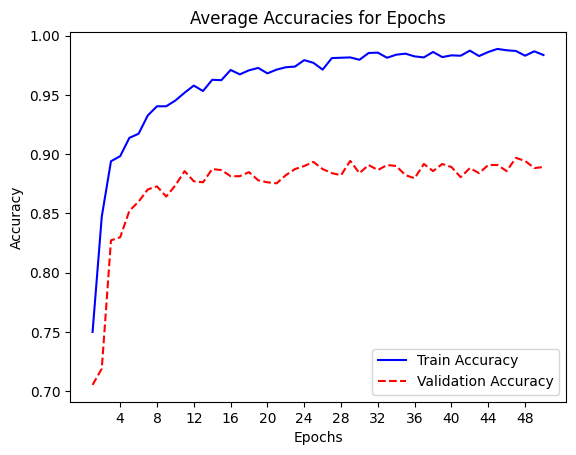

In [12]:
# Plot train vs validation accuracies per epoch

epochs = range(1, len(avg_accuracies) + 1)

plt.plot(epochs, avg_accuracies, label='Train Accuracy', color='blue')
plt.plot(epochs, avg_val_accuracies, label='Validation Accuracy', color='red', linestyle='--')

plt.title('Average Accuracies for Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Set x-axis ticks at every 4 epochs
plt.xticks(range(4, len(avg_accuracies) + 1, 4))

plt.show()

In [13]:
# prepare unseen test dataset and adjust batch size

test_gen = ImageDataGenerator(rescale=1/255.0) # just rescaling for test data
test_ds = test_gen.flow_from_dataframe(test_dataset, x_col='PATH', y_col='LABELS',
                                       target_size=(width,height),
                                       class_mode = 'categorical', 
                                       color_mode = 'rgb',
                                       batch_size = 1)

Found 292 validated image filenames belonging to 2 classes.


In [14]:
# test model accuracy and assign prediction and ground truth labels

lentest = len(test_ds)

test_acc_list = []
ypred_list = []
ytest = np.array([])
batch_size = 1  # adjust the batch size

for i in range(lentest):
    images, labels = test_ds.next()
    test_loss, test_acc = model.evaluate(images, labels, verbose=0)
    test_acc_list.append(test_acc)
    ypred = model.predict(images, verbose=0)
    ypred = np.argmax(ypred, axis=1) # the predicted labels
    ypred_list.extend(ypred)
    ytest = np.concatenate((ytest, labels.argmax(axis=1)), axis=0)  # the ground truth labels

#print(f"Test accuracy for each iteration: {test_acc_list}")
print(f"Model accuracy on test: {statistics.mean(test_acc_list) * 100:.2f}%")

Model accuracy on test: 93.15%


In [15]:
# This confusion matrix style have been taken from https://github.com/DTrimarchi10/confusion_matrix/blob/815c39cf1bd297c59de83d038fb293a12186c6a8/cf_matrix.py

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["number: {0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)
    plt.savefig(f'{model_name}.png', dpi=300)
    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

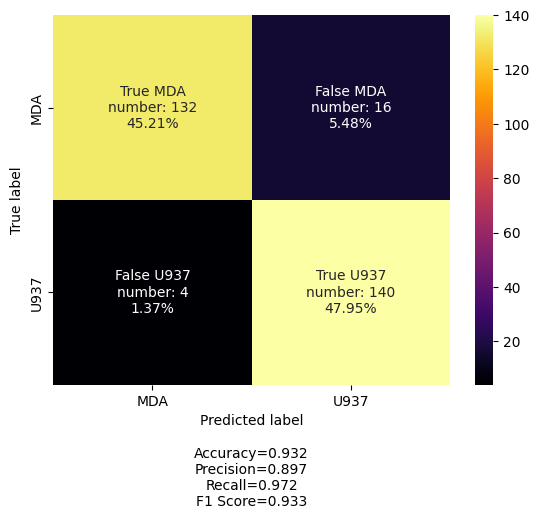

In [16]:
# Confusion matrix, labels and colormap

conf_matrix = confusion_matrix(ytest, ypred_list)

labels = ['True MDA','False MDA','False U937','True U937']
categories = ['MDA','U937']
make_confusion_matrix(conf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='inferno')

In [17]:
# compute tp, tp_and_fn and tp_and_fp for all classes
tp_and_fn = conf_matrix.sum(1)
tp_and_fp = conf_matrix.sum(0)
tp = conf_matrix.diagonal()

precision = tp / tp_and_fp
recall = tp / tp_and_fn

In [18]:
# calculate mean test accuracy
test_accuracy = statistics.mean(test_acc_list)

# Dictionary to assign training metrics
results = {
    'Architecture' : str(model_name),
    'CUDA Model': str(torch.cuda.get_device_name(0)),
    'Precision': str(precision),
    'Recall': str(recall),
    'Test Accuracy': str(test_accuracy),
    'Accuracy': str(avg_accuracies),
    'Total Training Time': str(total_time) + " sec",
    'Conf_matrix': str(conf_matrix),
    'Val Accuracy': str(avg_val_accuracies),
    'Fold Accuracy': str(epoch_accuracies),
    #'Model Summary' : str(short_model_summary),
}

# Write the dictionary to a file
with open('trainingresults.txt', 'w') as f:
    f.write('dict = ' + str(results) + '\n')

In [19]:
# Download training metrics with confusion matrix

files.download("trainingresults.txt")
files.download(f'{model_name}.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
#files.download(f'accloss{model_name}.png')
#stringlist = []
#model.summary(print_fn=lambda x: stringlist.append(x))
#short_model_summary = "\n".join(stringlist)
#print(short_model_summary)
#!rm accloss{model_name}.png
#!rm {model_name}.png
#!rm trainingresults.txt